# Cleaning Modes With Rational Filters

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter

## GW150914

Download data

In [3]:
# !wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5
# !wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5

Set some parameters of GW150914

In [4]:
input = dict(model_list = [(2, 2, 0)], #l, m, n
             #peak_time (geocenter, in seconds)
             peak_time = 1126259462.4083147,
             # delta_t (in seconds)
             delta_t = 2.0*1e-3,
             # length of the analysis window (in second)
             window_width = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 2048,
             # sky localization
             ra = 1.95, dec = -1.27,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)

fit = qnm_filter.Network(**input)

Load data

In [5]:
fit.import_ligo_data('H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5')
fit.import_ligo_data('L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5')

Perform time alignment across detectors

In [6]:
fit.detector_alignment(**input)

Condition data 

In [7]:
fit.condition_data('original_data', **input)

Cholesky-decomposition of the covariance matrix 

In [8]:
fit.compute_acfs('original_data')
fit.cholesky_decomposition()

## Likelihood as a function of mass and spin

Sampling remnant mass and spin

In [9]:
chispace = np.arange(0.0, 0.95, 0.06)
massspace = np.arange(34, 100, 2.0)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

Interate over the samplings

In [10]:
likelihood_data = qnm_filter.parallel_compute(fit, massspace, chispace, **input)

Plot 2d contours

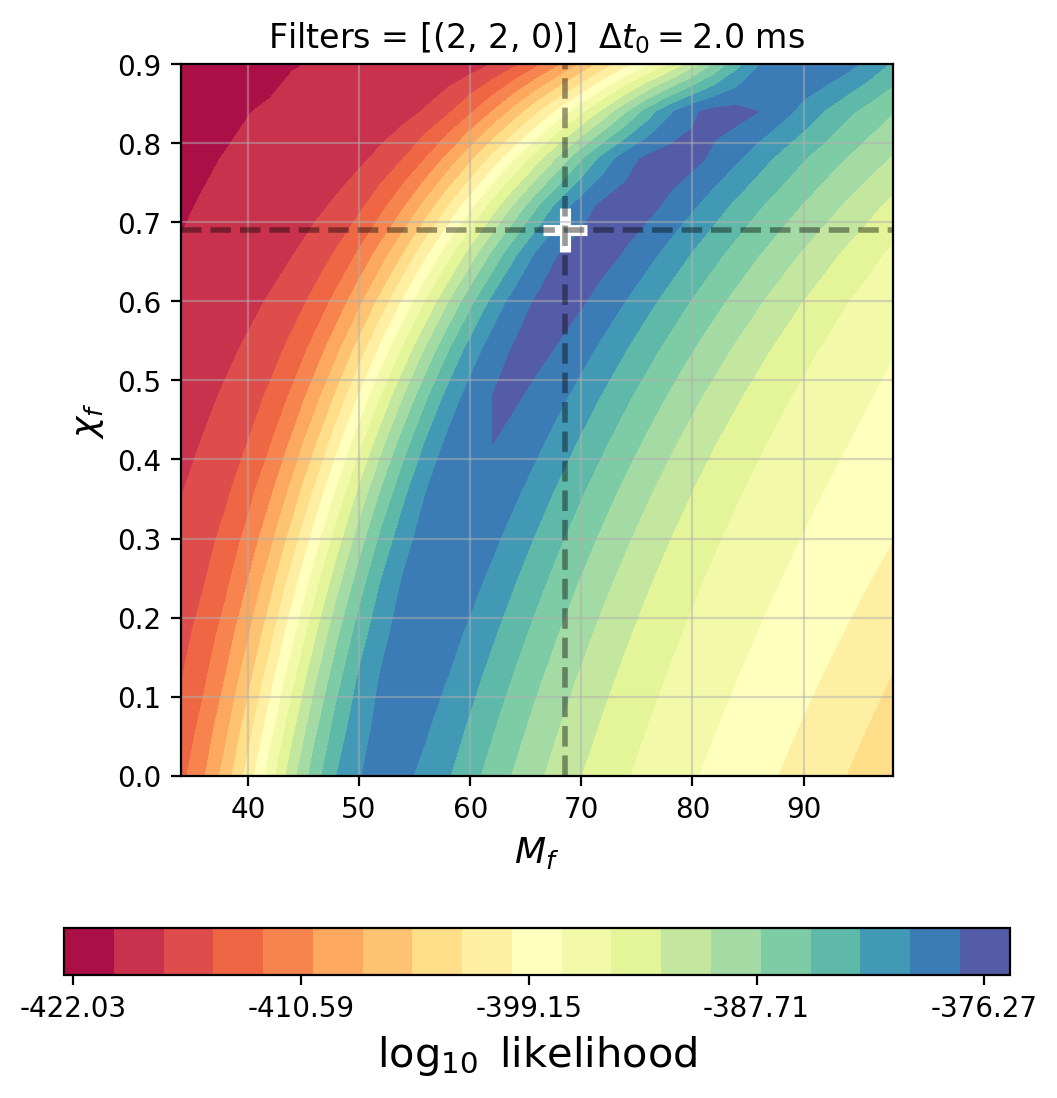

In [11]:
plotter_dict = input
plotter_dict.update({"show_fig": True, "save_fig": False, \
                     "fig_size": (6.1, 6.6), "IMR_result": (68.5, 0.69)})

qnm_filter.plotter(mass_grid, chi_grid, likelihood_data,\
                   **plotter_dict)